In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("train_v9rqX0R.csv")
test = pd.read_csv("test_AbJTz2l.csv")

test_original = test.copy()

for df in [data, test]:
    df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)
    df['Outlet_Size'].fillna('Unknown', inplace=True)
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({
        'LF': 'Low Fat',
        'low fat': 'Low Fat',
        'reg': 'Regular'
    })

drop_cols = ['Item_Identifier', 'Outlet_Identifier']


X = data.drop(columns=drop_cols + ['Item_Outlet_Sales'])
y = data['Item_Outlet_Sales']
test_X = test.drop(columns=drop_cols)

label_encoders = {}
for col in X.columns:
    if X[col].dtype == "object":
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        test_X[col] = le.transform(test_X[col])
        label_encoders[col] = le


rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)

rf.fit(X, y)
xgb_model.fit(X, y)
gbr.fit(X, y)


rf_train_preds = rf.predict(X)
xgb_train_preds = xgb_model.predict(X)
gbr_train_preds = gbr.predict(X)


train_preds_avg = (rf_train_preds + xgb_train_preds + gbr_train_preds) / 3

train_rmse = np.sqrt(mean_squared_error(y, train_preds_avg))
print(f"Training RMSE (Ensemble): {train_rmse:.2f}")


rf_preds = rf.predict(test_X)
xgb_preds = xgb_model.predict(test_X)
gbr_preds = gbr.predict(test_X)

final_predictions = (rf_preds + xgb_preds + gbr_preds) / 3


final_predictions = np.maximum(0, final_predictions)

submission = pd.DataFrame({
    'Item_Identifier': test_original['Item_Identifier'],
    'Outlet_Identifier': test_original['Outlet_Identifier'],
    'Item_Outlet_Sales': final_predictions
})


submission.to_csv('ensemble_submission.csv', index=False)

print("Submission file created: 'ensemble_submission.csv'")


Training RMSE (Ensemble): 689.50
Submission file created: 'ensemble_submission.csv'


# + MT AND CV

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

data = pd.read_csv("train_v9rqX0R.csv")
test = pd.read_csv("test_AbJTz2l.csv")


data['Item_Weight'].fillna(data['Item_Weight'].mean(), inplace=True)
data['Outlet_Size'] = data['Outlet_Size'].fillna('Unknown')

test['Item_Weight'].fillna(data['Item_Weight'].mean(), inplace=True)
test['Outlet_Size'] = test['Outlet_Size'].fillna('Unknown')

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'
})

test['Item_Fat_Content'] = test['Item_Fat_Content'].replace({
    'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'
})

data['Outlet_Age'] = 2025 - data['Outlet_Establishment_Year']
test['Outlet_Age'] = 2025 - test['Outlet_Establishment_Year']

data['Item_Visibility_Scaled'] = data['Item_Visibility'].apply(lambda x: x if x > 0 else 0.01)
test['Item_Visibility_Scaled'] = test['Item_Visibility'].apply(lambda x: x if x > 0 else 0.01)


label_encoders = {}
for col in ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type','Outlet_Size']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    test[col] = le.transform(test[col]) 
    label_encoders[col] = le

X = data.drop(['Item_Identifier','Item_Outlet_Sales','Outlet_Identifier'], axis=1)
y = data['Item_Outlet_Sales']

X_test = test.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor()

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best RF Params:", rf_grid.best_params_)
print("Best RF Score (RMSE):", (-rf_grid.best_score_)**0.5)


xgb_model = XGBRegressor()

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}


xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
xgb_grid.fit(X_train, y_train)

print("Best XGBoost Params:", xgb_grid.best_params_)
print("Best XGBoost Score (RMSE):", (-xgb_grid.best_score_)**0.5)

rf_model_tuned = RandomForestRegressor(n_estimators=200, max_depth=10)
xgb_model_tuned = XGBRegressor(n_estimators=200, learning_rate=0.1)

meta_model = LinearRegression()

stacking_model = StackingRegressor(estimators=[('rf', rf_model_tuned), ('xgb', xgb_model_tuned)], final_estimator=meta_model)

cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Stacking Model RMSE (CV):", (-cv_scores.mean())**0.5)


rf_pred = rf_grid.predict(X_val)
xgb_pred = xgb_grid.predict(X_val)
stack_pred = stacking_model.fit(X_train, y_train).predict(X_val)

# RMSE Calculation
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
stack_rmse = np.sqrt(mean_squared_error(y_val, stack_pred))

print(f'Random Forest RMSE: {rf_rmse}')
print(f'XGBoost RMSE: {xgb_rmse}')
print(f'Stacking Model RMSE: {stack_rmse}')

# Making predictions on the test data using the best models
rf_test_pred = rf_grid.predict(X_test)
xgb_test_pred = xgb_grid.predict(X_test)
stack_test_pred = stacking_model.fit(X_train, y_train).predict(X_test)

# Creating a final ensemble prediction (simple average of predictions)
final_test_pred = (rf_test_pred + xgb_test_pred + stack_test_pred) / 3

# Preparing the submission file
submission = pd.DataFrame({'Item_Identifier': test['Item_Identifier'],
                           'Outlet_Identifier': test['Outlet_Identifier'],
                           'Item_Outlet_Sales': final_test_pred})

submission.to_csv('submission_el_mt_cv.csv', index=False)

print("Submission file created!")


Best RF Params: {'max_depth': 5, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 100}
Best RF Score (RMSE): 1096.8389339404962
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best XGBoost Score (RMSE): 1091.2890384359318
Stacking Model RMSE (CV): 1109.9906069483045
Random Forest RMSE: 1020.5725402194263
XGBoost RMSE: 1029.201468603675
Stacking Model RMSE: 1043.6486283538732
Submission file created!


<Figure size 1400x800 with 0 Axes>

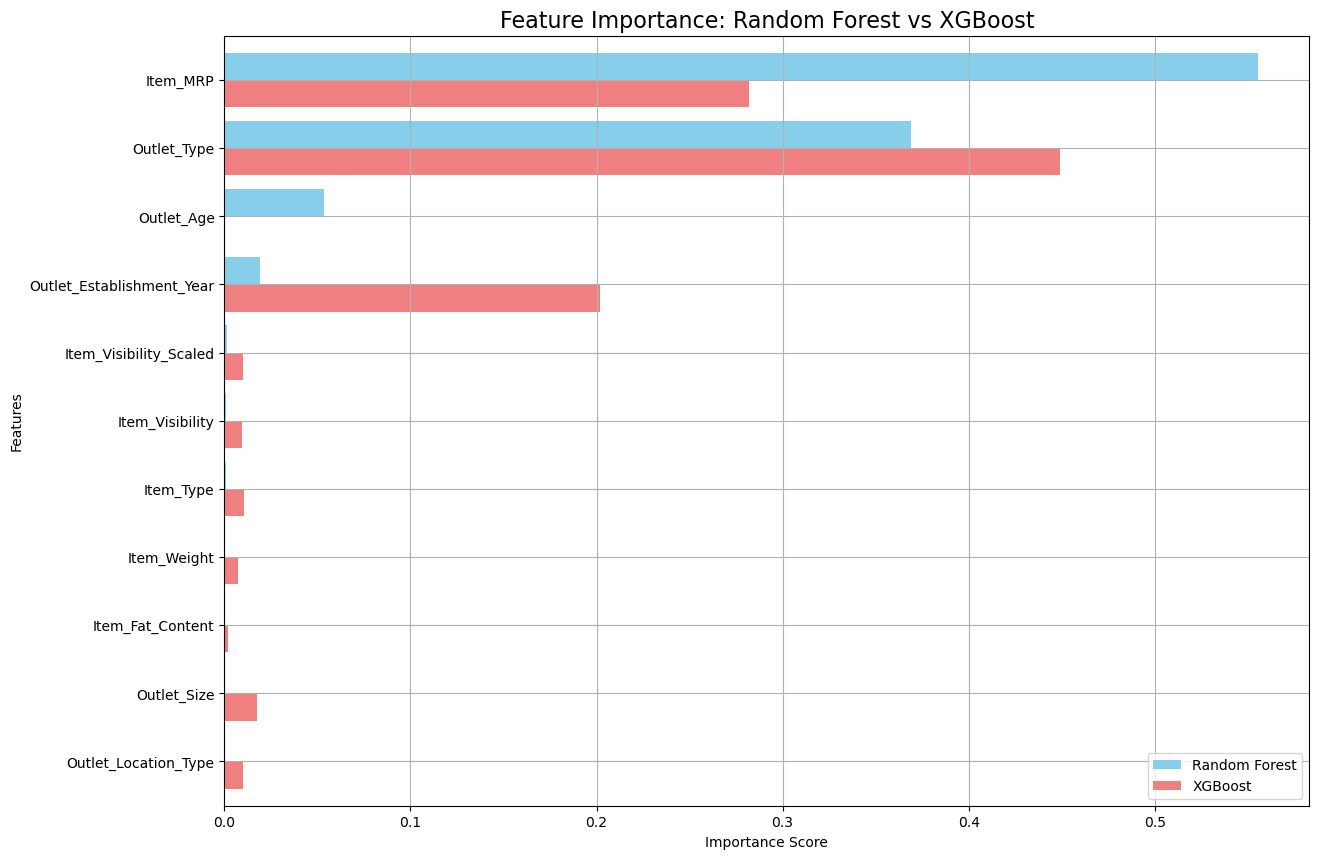

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


rf_importances = pd.Series(rf_grid.best_estimator_.feature_importances_, index=X_train.columns)
xgb_importances = pd.Series(xgb_grid.best_estimator_.feature_importances_, index=X_train.columns)
feature_importance_df = pd.DataFrame({
    'Random Forest': rf_importances,
    'XGBoost': xgb_importances
})
feature_importance_df = feature_importance_df.sort_values('Random Forest', ascending=False)
plt.figure(figsize=(14, 8))
feature_importance_df.plot(kind='barh', figsize=(14, 10), width=0.8, color=['skyblue', 'lightcoral'])
plt.title('Feature Importance: Random Forest vs XGBoost', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis() 
plt.legend()
plt.grid(True)
plt.show()


# Removing Visibility scaled

<Figure size 1400x800 with 0 Axes>

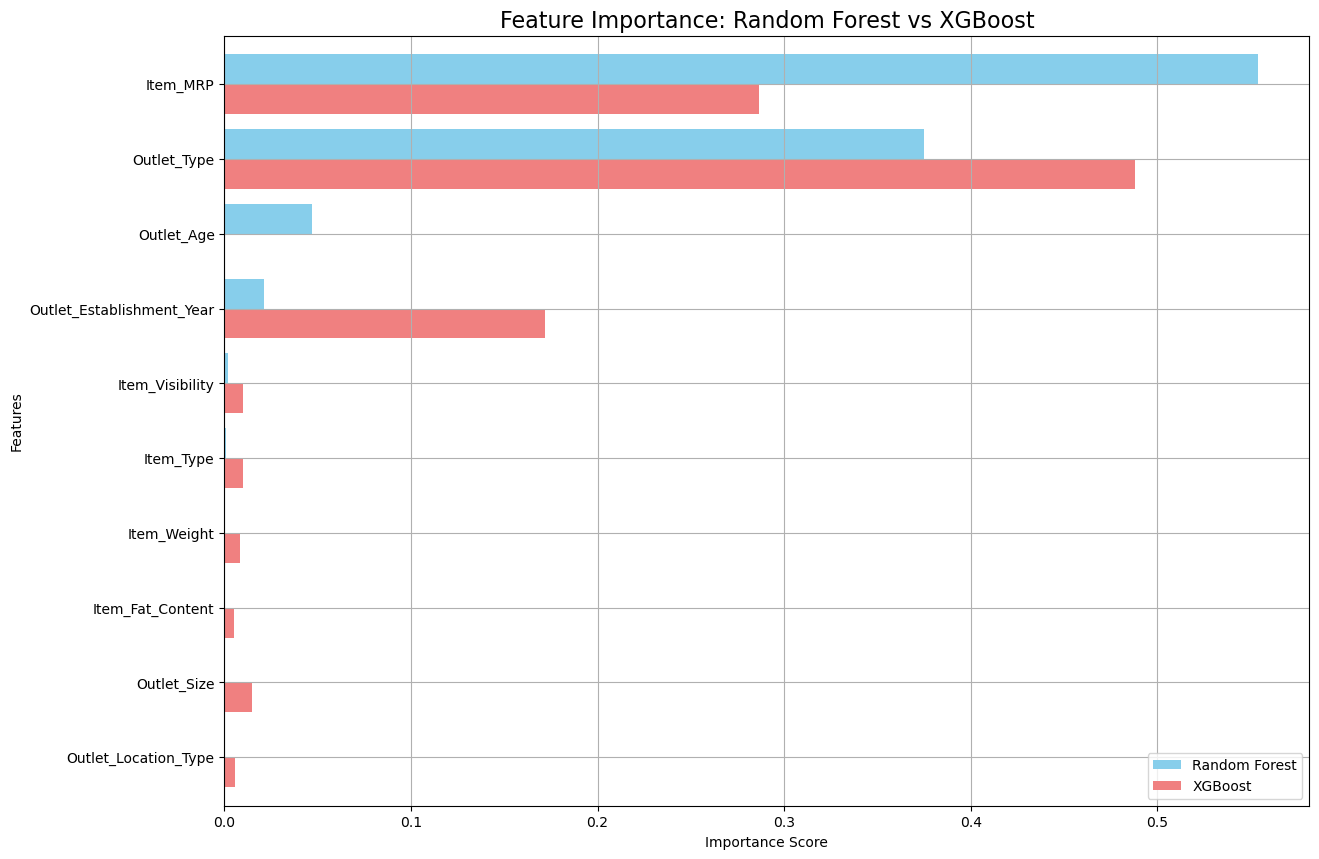

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Random Forest Feature Importance
rf_importances = pd.Series(rf_grid.best_estimator_.feature_importances_, index=X_train.columns)

# XGBoost Feature Importance
xgb_importances = pd.Series(xgb_grid.best_estimator_.feature_importances_, index=X_train.columns)

# Combine into a DataFrame
feature_importance_df = pd.DataFrame({
    'Random Forest': rf_importances,
    'XGBoost': xgb_importances
})

# Sort by Random Forest importance (or you can choose to sort by XGBoost too)
feature_importance_df = feature_importance_df.sort_values('Random Forest', ascending=False)

# Plotting
plt.figure(figsize=(14, 8))
feature_importance_df.plot(kind='barh', figsize=(14, 10), width=0.8, color=['skyblue', 'lightcoral'])
plt.title('Feature Importance: Random Forest vs XGBoost', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Highest at the top
plt.legend()
plt.grid(True)
plt.show()

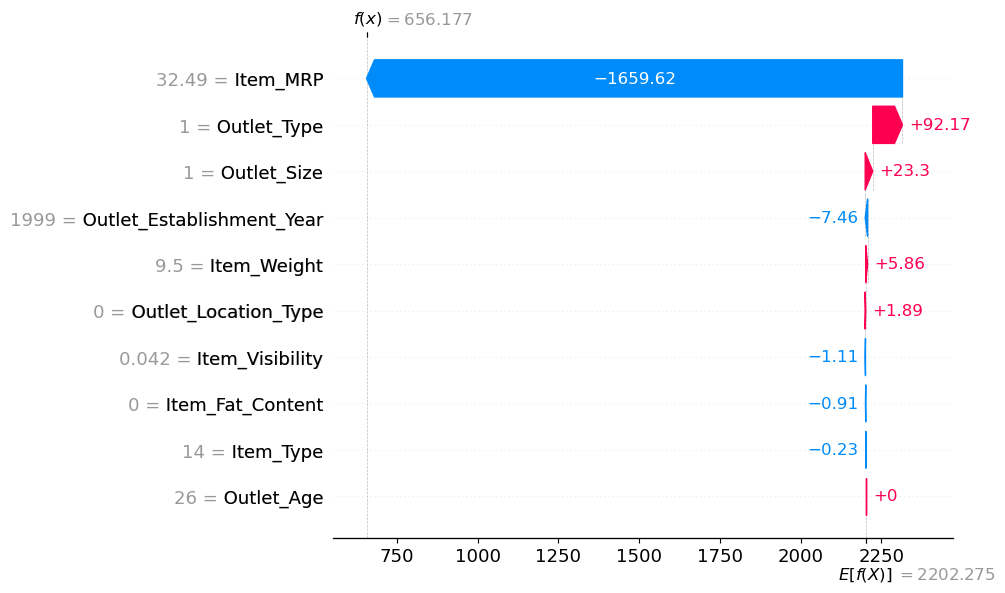

In [26]:
import shap

explainer = shap.Explainer(xgb_grid.best_estimator_)
sample_idx = 5  
sample = X_val.iloc[[sample_idx]]
shap_values = explainer(sample)
shap.plots.waterfall(shap_values[0])